In [84]:
import geopandas as gpd                 # spatial data
import pandas as pd                     # tabular data
import numpy as np                      # numerical ops
import matplotlib.pyplot as plt         # plots

from libpysal.weights import Queen      # spatial weights
from esda.moran import Moran            # Moran’s I statistic
from esda.moran import Moran_Local
from splot.esda import moran_scatterplot # plot Moran scatterplot

In [86]:
%matplotlib inline

# Load Week 2 output GeoJSON
gdf = gpd.read_file("elasticity_simulation.csv")
print("Rows loaded:", len(gdf))

# Convert empty strings to actual NaNs 
gdf["elasticity_estimate"].replace('', np.nan, inplace=True)
# Drop rows with missing elasticity
gdf = gdf.dropna(subset=["elasticity_estimate"])
print("Rows after dropping NaNs:", len(gdf))

Rows loaded: 113
Rows after dropping NaNs: 15


/var/folders/w3/f3zhp9t17_7cxs5hc0t1bznw0000gn/T/ipykernel_46889/1570193273.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf["elasticity_estimate"].replace('', np.nan, inplace=True)


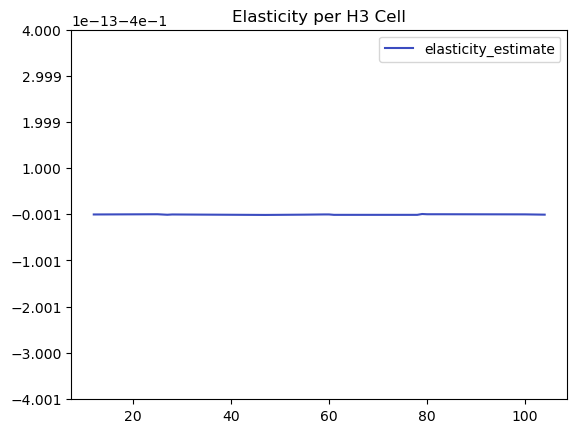

In [88]:
# Plot elasticity
# Convert strings to floats first
gdf["elasticity_estimate"] = pd.to_numeric(gdf["elasticity_estimate"], errors="coerce")
gdf.plot(column="elasticity_estimate", cmap="coolwarm", legend=True)
plt.title("Elasticity per H3 Cell")
plt.show()

In [94]:
# Tell GeoPandas that this is your geometry column
gdf = gpd.GeoDataFrame(gdf, geometry="geometry")

# Create spatial weights matrix (Queen contiguity)
w = Queen.from_dataframe(gdf)

# Row-standardize weights
w.transform = "R"

# Calculate Moran's I
y = gdf["elasticity_estimate"]
moran = Moran(y, w)

print(f"Moran’s I: {moran.I:.3f}, p-value: {moran.p_sim:.3f}")

# nearby cells have somewhat similar elasticity values (slight positive spatial correlation)
# p value is not statistically significant. we want p value < 0.05. 
# no strong evidence that spatial clustering of elasticity exists, it could be due to randomness.

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 5, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
Moran’s I: 0.128, p-value: 0.322


/var/folders/w3/f3zhp9t17_7cxs5hc0t1bznw0000gn/T/ipykernel_46889/3739948496.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)
/opt/anaconda3/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 0, 3, 4, 5, 6.
  W.__init__(self, neighbors, ids=ids, **kw)


<Figure size 600x600 with 0 Axes>

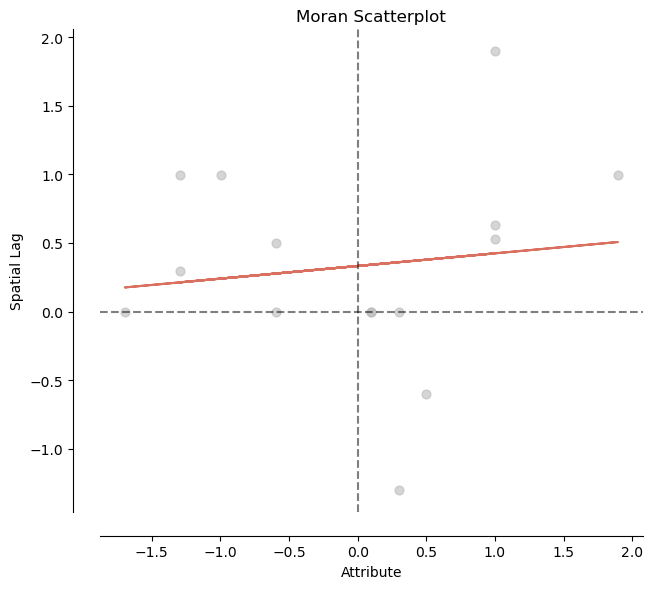

AttributeError: 'Moran' object has no attribute 'q'

In [74]:
# Plot Moran scatterplot
plt.figure(figsize=(6, 6))
moran_scatterplot(moran, zstandard=True)
plt.title("Moran Scatterplot")
plt.show()

# Add cluster classification (hot/cold spots)
gdf["moran_cluster"] = ["Not Significant"] * len(gdf)
sig = moran.q
gdf.loc[(sig==1), "moran_cluster"] = "High-High"
gdf.loc[(sig==2), "moran_cluster"] = "Low-Low"

# Plot clusters
gdf.plot(column="moran_cluster", legend=True)
plt.title("Elasticity Clusters")
plt.show()

# Save clustered output
gdf.to_file("h3_elasticity_clusters.geojson", driver="GeoJSON")
print("✅ Saved: h3_elasticity_clusters.geojson")